In [92]:
from os import listdir
from os.path import splitext
from os.path import join
import statistics
import skvideo

skvideo.setFFmpegPath(
    r"C:\Users\ion\anaconda3\envs\tf-gpu\Lib\site-packages\ffmpeg-4.3.1-2020-10-01-full_build\bin"
)
import skvideo.io
import json
import cv2

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

### Functions ####

In [231]:
# Distribution of classes for training set
def AW2_distplotter(distribution,title, overlay=True):
    # Distribution of class for training set in percentages
    if overlay == True:
        percentages = {name:round((value/sum(distribution.values()))*100,2) for name, value in zip(names_class, distribution.values())}
    
    fig, axes = plt.subplots(figsize=(10,8))
    ax1 = axes.bar(distribution.keys(), distribution.values(), color=('b','g','r','c','m','y','k'))
    axes.set_title(title)
    
    if overlay == True:
        for rect, value in zip(ax1, percentages.values()):
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2, height, f'{height}' , ha='center', va='bottom')
            plt.text(rect.get_x() + rect.get_width()/2, height/1.05, f'{value}%', color='white', ha='center', va='top')

## Explanation of different datasets
The Aff-Wild2 dataset is used for training, validation and testing. While the AFEW 7.0 dataset is only used for testing. 

#### Aff-Wild2
In this dataset all videos are in one folder. Each video has a corresponding .txt file where each frame is annotated with the correspending facial expression class at that frame. In each video multiple emotions are displayed, thats why the annotation is per frame.

In [2]:
# Aff-Wild2 = AW2
# filenames = FN

### Aff-wild2 ###
# Directories for labels/annotations for each set
AW2_dir_train_labels = (
    r"D:\Aff-Wild2 Dataset\Aff-wild2\Videos\annotations\EXPR_Set\Training_Set"
)
AW2_dir_val_labels = (
    r"D:\Aff-Wild2 Dataset\Aff-wild2\Videos\annotations\EXPR_Set\Validation_Set"
)

# Directories for videos
AW2_dir_allvideos = r"D:\Aff-Wild2 Dataset\Aff-wild2\Videos\all_videos"

In [3]:
# Save the filenames in a list for each set, and split the filename from the extension
AW2_train_FN = listdir(AW2_dir_train_labels)
AW2_train_FN_split = [splitext(file) for file in AW2_train_FN]

AW2_val_FN = listdir(AW2_dir_val_labels)
AW2_val_FN_split = [splitext(file) for file in AW2_val_FN]

AW2_videos_FN = listdir(AW2_dir_allvideos)
AW2_videos_FN_split = [splitext(file) for file in AW2_videos_FN]

# Aff-wild2 Dataset Size #

In [4]:
# Size of each set
print(f"The training-set contains: {len(AW2_train_FN)} videos")
print(f"The validation-set contains: {len(AW2_val_FN)} videos")
print(
    f"The test-set contains: {len(AW2_videos_FN) - (len(AW2_train_FN) + len(AW2_val_FN))} videos"
)
print(f"The whole dataset contains: {len(AW2_videos_FN)} videos")

The training-set contains: 253 videos
The validation-set contains: 70 videos
The test-set contains: 225 videos
The whole dataset contains: 548 videos


In [5]:
# Checking if the labeled filenames corresponds to the videos
train_size = 0
for i in AW2_train_FN_split:
    for j in AW2_videos_FN_split:
        if i[0] == j[0]:
            train_size += 1
print(train_size)

246


The results show that only 246 labels are matched to videos, while there were 253 labeled videos. **Some videos contain two persons, so the labels are for one person on the left or right.**

In [6]:
# Checking if the labeled filenames corresponds to the videos (and disregarding if its on left or right)
train_size = 0
for i in AW2_train_FN_split:
    for j in AW2_videos_FN_split:
        if "_left" in i[0]:
            a = i[0].replace("_left", "")
        elif "_right" in i[0]:
            a = i[0].replace("_right", "")
        else:
            a = i[0]
        if a == j[0]:
            train_size += 1
# Labels is equal to videos now
print(f"Training dataset is indeed = {train_size} videos")

# Checking if the labeled filenames corresponds to the videos (and disregarding if its on left or right)
val_size = 0
for i in AW2_val_FN_split:
    for j in AW2_videos_FN_split:
        if "_left" in i[0]:
            a = i[0].replace("_left", "")
        elif "_right" in i[0]:
            a = i[0].replace("_right", "")
        else:
            a = i[0]
        if a == j[0]:
            val_size += 1
# Labels is equal to videos now
print(f"Validation dataset is indeed = {val_size} videos")

Training dataset is indeed = 253 videos
Validation dataset is indeed = 70 videos


# Sequence length of each video

V1 and V2 use the metadata to retreive the amount of frames in each video. While fast, it can be inaccurate sometimes. Thats why I am using V3 to check the videos manually.

### Version 1

In [62]:
# Create dictionary of sequence length of each video with ffprobe in skvideo
AW2_seqlength = {}
AW2_seqlength_without_extension = {}
for video in AW2_videos_FN:
    metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
    framerate = (metadata.get("video").get("@r_frame_rate"))
    frames = int(metadata.get("video").get("@nb_frames"))
    width = int(metadata.get("video").get("@width"))
    height = int(metadata.get("video").get("@height"))
    AW2_seqlength[video] = [frames, height, width, 3]

    name, ext = splitext(video)
    AW2_seqlength_without_extension[name] = [frames, height, width, 3]

In [63]:
AW2_seqlength

{'1-30-1280x720.mp4': [10355, 720, 1280, 3],
 '10-60-1280x720.mp4': [2501, 720, 1280, 3],
 '100-29-1080x1920.mp4': [2639, 1920, 1080, 3],
 '101-30-1080x1920.mp4': [5153, 1920, 1080, 3],
 '102-30-640x360.mp4': [2983, 360, 640, 3],
 '102.avi': [4777, 360, 480, 3],
 '103-30-384x480.mp4': [771, 480, 384, 3],
 '103.avi': [26617, 360, 600, 3],
 '104-17-720x480.mp4': [2425, 480, 720, 3],
 '105-30-1280x720.mp4': [1501, 720, 1280, 3],
 '105.avi': [10076, 360, 640, 3],
 '106-30-720x1280.mp4': [1404, 1280, 720, 3],
 '106.avi': [8163, 360, 480, 3],
 '107-30-640x480.mp4': [73, 480, 640, 3],
 '107.avi': [5315, 360, 640, 3],
 '108-15-640x480.mp4': [478, 480, 640, 3],
 '108.avi': [4678, 360, 640, 3],
 '109-30-1280x720.mp4': [1045, 720, 1280, 3],
 '11-24-1920x1080.mp4': [5389, 1080, 1920, 3],
 '110-30-270x480.mp4': [9978, 480, 270, 3],
 '110.avi': [5504, 360, 640, 3],
 '111-25-1920x1080.mp4': [771, 1080, 1920, 3],
 '111.avi': [7246, 360, 640, 3],
 '112-30-640x360.mp4': [6002, 360, 640, 3],
 '112.avi': 

### Version 2

In [64]:
# Create dictionary of sequence length of each video with ffprobe in skvideo and opencv to capture the amount of frames
AW2_seqlength_V2 = {}

for video in AW2_videos_FN:
    metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
    width = int(metadata.get("video").get("@width"))
    height = int(metadata.get("video").get("@height"))

    cap = cv2.VideoCapture(join(AW2_dir_allvideos, video))
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    AW2_seqlength_V2[video] = [frames, height, width, 3]

In [65]:
# Checking if the video length is the same with each method
AW2_seqlength == AW2_seqlength_V2

True

### Version 3

In [87]:
# Create dictionary of sequence length of each video with ffprobe in skvideo and opencv to capture the amount of frames manually
AW2_seqlength_V3 = {}

counter = 0
for video in AW2_videos_FN:
    print(counter)
    counter += 1
    metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
    width = int(metadata.get("video").get("@width"))
    height = int(metadata.get("video").get("@height"))

    frames = count_frames_manual(cv2.VideoCapture(join(AW2_dir_allvideos, video)))
    AW2_seqlength_V3[video] = [frames, height, width, 3]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [107]:
# Checking if the video length is the same between V1(=V2) and V3
AW2_seqlength == AW2_seqlength_V3

False

In [108]:
for video in AW2_videos_FN:
    if (AW2_seqlength.get(video) == AW2_seqlength_V3.get(video)) == False:
        print(
            video,
            f"V1: {AW2_seqlength_V2.get(video)} and V3: {AW2_seqlength_V3.get(video)}",
        )

252.mp4 V1: [2756, 360, 640, 3] and V3: [2755, 360, 640, 3]
video30.mp4 V1: [8217, 1080, 1920, 3] and V3: [8197, 1080, 1920, 3]


**Two videos seem to have less actual frames then the metadata has shown:**

- 252.mp4  
    - V1: [2756, 360, 640, 3]
    - V3: [2755, 360, 640, 3]
- video30.mp4 
    - V1: [8217, 1080, 1920, 3]
    - V3: [8197, 1080, 1920, 3]
***

In [ ]:
# Save json file with all video's names and shapes = (n_frames, width, height, colour channels)
with open("AW2_video_shapes.json", "w") as fp:
    json.dump(AW2_seqlength, fp)

## Load the saved video shapes file 

In [147]:
# Load Aff-Wild2 video_shapes.json
with open("AW2_video_shapes.json", "r") as fp:
    AW2_video_shapes = json.load(fp)

## Some Summary statistics about video frames

In [151]:
AW2_all_sequenceslength = [items[0] for items in list(AW2_video_shapes.values())]
print(f'The mean length of all sequences is: {np.mean(AW2_all_sequenceslength)} frames')
print(f'The median length of all sequences is: {np.median(AW2_all_sequenceslength)} frames')
print(f'The SD of length of all sequences is: {np.std(AW2_all_sequenceslength)} frames')

The mean length of all sequences is: 4763.456204379562 frames
The median length of all sequences is: 3937.0 frames
The SD of length of all sequences is: 4067.4542227198276 frames


### Scatterplot of sequence length per resolution

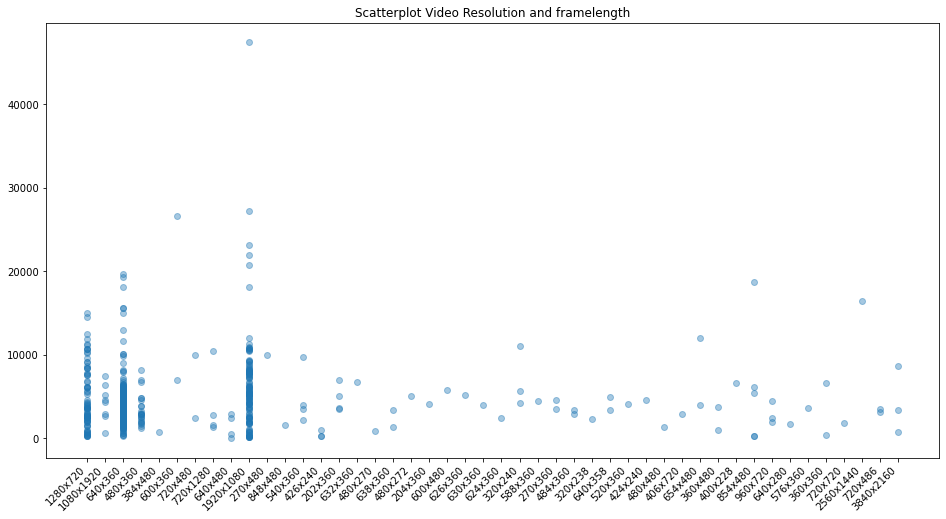

In [244]:
names = [(str(items[2])+"x"+ str(items[1])) for items in list(AW2_seqlength.values())]
fig, axes = plt.subplots(figsize=(16,8))
axes.set_title('Scatterplot Video Resolution and framelength')
plt.xticks(rotation=45, ha='right')
axes.scatter(names,  AW2_all_sequenceslength, alpha=0.4);

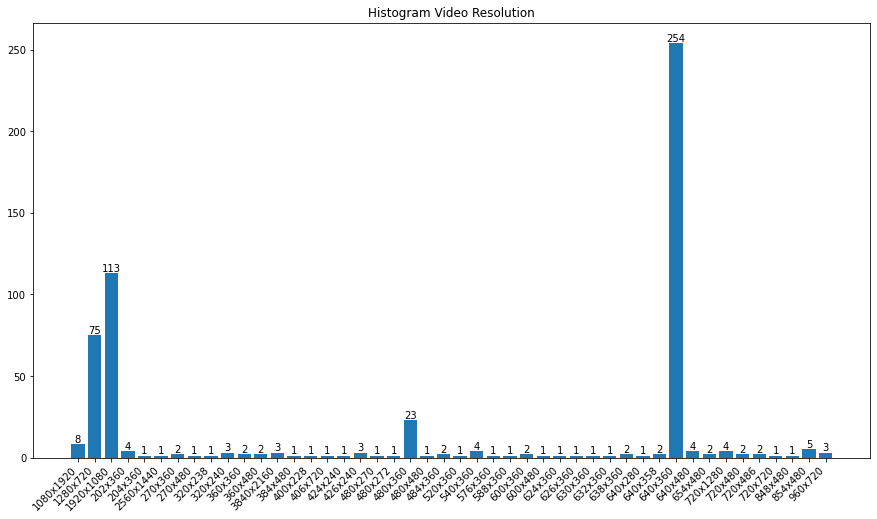

In [260]:
AW2_res_dist = {resolution:names.count(resolution) for resolution in sorted(set(names))}

fig, axes = plt.subplots(figsize=(15,8))
ax1=axes.bar(AW2_res_dist.keys(), AW2_res_dist.values())
axes.set_title('Histogram Video Resolution')
plt.xticks(rotation=45, ha='right')
for rect, value in zip(ax1, percentages.values()):
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2, height, f'{height}' , ha='center', va='bottom');

## Framerate of each video 

In [66]:
# Grab the framerate for each video in the Aff-wild2 dataset. 
# Then convert it to avg framerate value in decimals.
AW2_framerates = {}
for video in AW2_videos_FN:
    metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
    num, denom = (metadata.get("video").get("@avg_frame_rate")).split('/')
    AW2_framerates[video] = (int(num)/int(denom))

In [67]:
# Put all framerates in a list
AW2_all_framerates = [AW2_framerates.get(video) for video in AW2_videos_FN]

# Count the occurence of each framerate to get the distribution
AW2_framerates_dist = {framerate:AW2_all_framerates.count(framerate) for framerate in sorted(set(AW2_all_framerates))}

In [68]:
AW2_framerates_dist

{7.5: 1,
 7.666666666666667: 1,
 10.0: 1,
 13.498655753355806: 1,
 13.75: 1,
 14.60983606557377: 1,
 15.452: 1,
 15.916666666666666: 1,
 16.0: 1,
 16.500881360701758: 1,
 17.0: 1,
 18.227513227513228: 1,
 18.242368177613322: 1,
 18.625991458206222: 1,
 18.990912289913034: 1,
 19.4446538337662: 1,
 19.496083845143943: 1,
 20.08349677793497: 1,
 20.083507652568425: 1,
 20.08499381529154: 1,
 20.10213556174559: 1,
 20.130584192439862: 1,
 20.319103494027367: 1,
 20.327554899724305: 1,
 20.348271766041144: 1,
 20.382387847723045: 1,
 20.455607476635514: 1,
 20.476190476190474: 1,
 20.54380664652568: 1,
 20.573811931243682: 1,
 20.604395604395606: 1,
 20.805484147386462: 1,
 20.817088345085025: 1,
 20.829545454545453: 1,
 20.91076625238116: 1,
 20.930771188355017: 1,
 20.969075172614996: 1,
 21.068813947667618: 1,
 21.119500130174433: 1,
 21.123989534650935: 1,
 21.243750796640654: 1,
 21.32001647446458: 1,
 21.346329576606763: 1,
 21.353173938293736: 1,
 21.479713603818617: 1,
 21.58251305

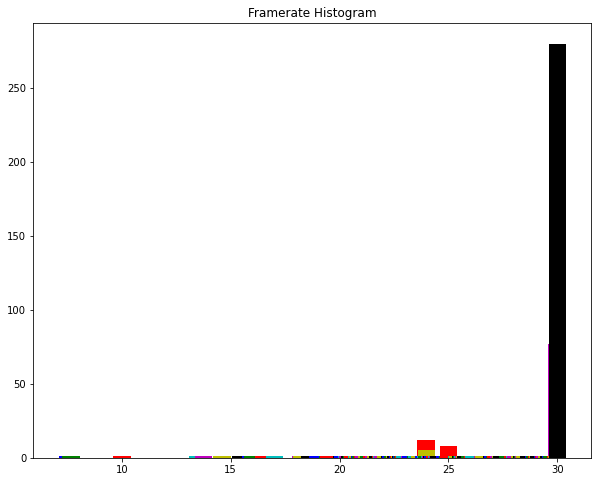

In [263]:
AW2_distplotter(AW2_framerates_dist,"Framerate Histogram", False)

fig, axes = plt.subplots(figsize=(15,8))
ax1=axes.bar(AW2_framerates_dist.keys(), AW2_framerates_dist.values())
axes.set_title('Histogram Video Resolution')
plt.xticks(rotation=45, ha='right')
for rect, value in zip(ax1, percentages.values()):
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2, height, f'{height}' , ha='center', va='bottom');

## Classes per video in training and validation set ##

In [69]:
# Load all txt files and create dictionary where each key is the filename and value is all the values (annotations) in the text file
AW2_train_classes = {}
for ann_file in AW2_train_FN:
    with open(join(AW2_dir_train_labels, ann_file), "r") as fp:
        AW2_train_classes[ann_file] = np.array(fp.read().splitlines()[1:], dtype=int)

AW2_val_classes = {}
for ann_file in AW2_val_FN:
    with open(join(AW2_dir_val_labels, ann_file), "r") as fp:
        AW2_val_classes[ann_file] = np.array(fp.read().splitlines()[1:], dtype=int)

In [174]:
AW2_train_classes

{'1-30-1280x720.txt': array([4, 4, 4, ..., 4, 4, 4]),
 '10-60-1280x720.txt': array([0, 0, 0, ..., 4, 4, 4]),
 '10-60-1280x720_right.txt': array([-1, -1, -1, ..., -1, -1, -1]),
 '100-29-1080x1920.txt': array([0, 0, 0, ..., 4, 4, 4]),
 '101-30-1080x1920.txt': array([-1, -1, -1, ...,  4,  4,  4]),
 '102-30-640x360.txt': array([ 0,  0,  0, ..., -1, -1, -1]),
 '102.txt': array([0, 0, 0, ..., 5, 5, 5]),
 '103-30-384x480.txt': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -

In [70]:
# Checking if the lentgh of each text annotated file is the same as the amount of frames in a video.
for ann_file in AW2_train_FN:
    name, ext = splitext(ann_file)
    if "_left" in name:
        name = name.replace("_left", "")
    elif "_right" in name:
        name = name.replace("_right", "")
    x = AW2_seqlength_without_extension.get(name)[0]
    y = len(AW2_train_classes.get(ann_file))
    print([ann_file], f"has {y-x} more annotation than frames")

['1-30-1280x720.txt'] has 1 more annotation than frames
['10-60-1280x720.txt'] has 1 more annotation than frames
['10-60-1280x720_right.txt'] has 1 more annotation than frames
['100-29-1080x1920.txt'] has 1 more annotation than frames
['101-30-1080x1920.txt'] has 1 more annotation than frames
['102-30-640x360.txt'] has 1 more annotation than frames
['102.txt'] has 1 more annotation than frames
['103-30-384x480.txt'] has 1 more annotation than frames
['103.txt'] has 1 more annotation than frames
['104-17-720x480.txt'] has 1 more annotation than frames
['105-30-1280x720.txt'] has 1 more annotation than frames
['105.txt'] has 1 more annotation than frames
['106-30-720x1280.txt'] has 1 more annotation than frames
['106.txt'] has 2 more annotation than frames
['107-30-640x480.txt'] has 0 more annotation than frames
['107.txt'] has 1 more annotation than frames
['108-15-640x480.txt'] has 1 more annotation than frames
['108.txt'] has 2 more annotation than frames
['109-30-1280x720.txt'] has 1

In [71]:
# Checking if the lentgh of each text annotated file is the same as the amount of frames in a video.
for ann_file in AW2_val_FN:
    name, ext = splitext(ann_file)
    if "_left" in name:
        name = name.replace("_left", "")
    elif "_right" in name:
        name = name.replace("_right", "")
    x = AW2_seqlength_without_extension.get(name)[0]
    y = len(AW2_val_classes.get(ann_file))
    print([ann_file], f" has {y-x} more annotation than frames")

['117.txt']  has 1 more annotation than frames
['118-30-640x480.txt']  has 0 more annotation than frames
['118.txt']  has 1 more annotation than frames
['119-30-848x480.txt']  has 1 more annotation than frames
['119.txt']  has 2 more annotation than frames
['120-30-1280x720.txt']  has 0 more annotation than frames
['120.txt']  has 1 more annotation than frames
['121-24-1920x1080.txt']  has 1 more annotation than frames
['121.txt']  has 1 more annotation than frames
['122-60-1920x1080-2.txt']  has 1 more annotation than frames
['122-60-1920x1080-3.txt']  has 1 more annotation than frames
['122-60-1920x1080-4.txt']  has 1 more annotation than frames
['122.txt']  has 1 more annotation than frames
['123-25-1920x1080.txt']  has 1 more annotation than frames
['123.txt']  has 1 more annotation than frames
['124-30-720x1280.txt']  has 1 more annotation than frames
['125-25-1280x720.txt']  has 1 more annotation than frames
['125.txt']  has 1 more annotation than frames
['126.txt']  has 1 more a


It seems that each annotated file has about 0 to 2 more annotations than the amount of frames in a video
***

### Distribution of each class per video and set ###

In [158]:
names_class = ["neutral", "anger", "disgust", "fear", "happiness", "sadness", "surprise"]

# Facial Expression Class distribution per video of training set
AW2_train_classdist = {}
for ann_file in AW2_train_FN:
    values = AW2_train_classes.get(ann_file)
    AW2_train_classdist[ann_file] = {name: np.sum(values == i) for name, i in zip(names_class, range(0, 7))}

# Facial Expression Class distribution per video of validation set
AW2_val_classdist = {}
for ann_file in AW2_val_FN:
    values = AW2_val_classes.get(ann_file)
    AW2_val_classdist[ann_file] = {name: np.sum(values == i) for name, i in zip(names_class, range(0, 7))}

In [169]:
AW2_train_classdist

{'1-30-1280x720.txt': {'neutral': 7775,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 2581,
  'sadness': 0,
  'surprise': 0},
 '10-60-1280x720.txt': {'neutral': 717,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 1222,
  'sadness': 0,
  'surprise': 202},
 '10-60-1280x720_right.txt': {'neutral': 45,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 481,
  'sadness': 0,
  'surprise': 0},
 '100-29-1080x1920.txt': {'neutral': 660,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 1917,
  'sadness': 0,
  'surprise': 18},
 '101-30-1080x1920.txt': {'neutral': 298,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 3505,
  'sadness': 0,
  'surprise': 0},
 '102-30-640x360.txt': {'neutral': 1221,
  'anger': 1726,
  'disgust': 0,
  'fear': 0,
  'happiness': 0,
  'sadness': 0,
  'surprise': 0},
 '102.txt': {'neutral': 985,
  'anger': 0,
  'disgust': 0,
  'fear': 891,
  'happiness': 0,
  'sadness': 1811,
  'surprise': 0},
 '103-30-384x480.txt': {'neutra

### Training set: Facial Expression Class distribution

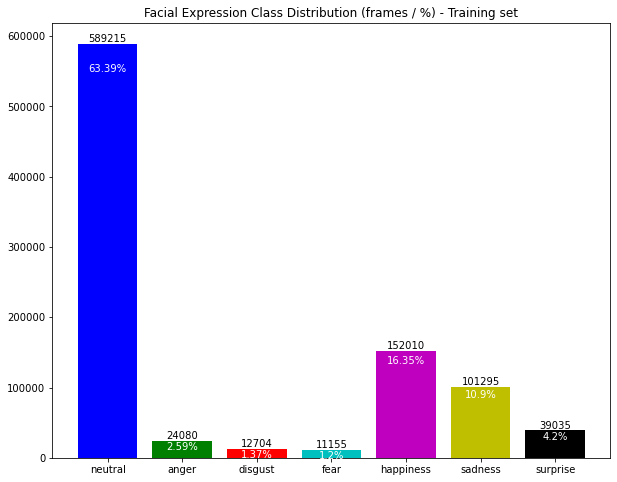

In [238]:
AW2_train_highlevel_dist = {i: 0 for i in names_class}
for ann_file in AW2_train_FN:
    values = AW2_train_classdist.get(ann_file)
    for name in AW2_train_highlevel_dist.keys():
        AW2_train_highlevel_dist[name] += values.get(name)

AW2_distplotter(AW2_train_highlevel_dist, "Facial Expression Class Distribution (frames / %) - Training set")

### Validation set: Facial Expression Class distribution

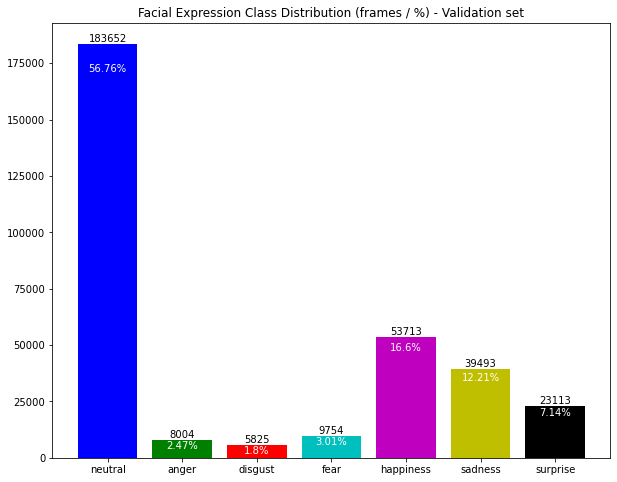

In [239]:
AW2_val_highlevel_dist = {i: 0 for i in names_class}
for ann_file in AW2_val_FN:
    values = AW2_val_classdist.get(ann_file)
    for name in AW2_val_highlevel_dist.keys():
        AW2_val_highlevel_dist[name] += values.get(name)
        
AW2_distplotter(AW2_val_highlevel_dist, "Facial Expression Class Distribution (frames / %) - Validation set")